In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from joblib import Parallel, delayed

from monge_alignment.utils import (
    apply_convolution,
    compute_psd,
    create_2d_gaussian_filter,
)

Tensorflow not install, you could not use those pipelines


In [2]:
train_data_numpy = np.load("data/MNIST/train_data.npy")
train_labels_numpy = np.load("data/MNIST/train_labels.npy")

In [44]:
height = 28
width = 28
sigma = 3

In [45]:
filters = []
dirs = np.linspace(0, 180, 12, endpoint=False)

for dir in dirs:
    domain = []
    gaussian_filter_image = create_2d_gaussian_filter(height, width, dir, sigma)
    filters.append(gaussian_filter_image)

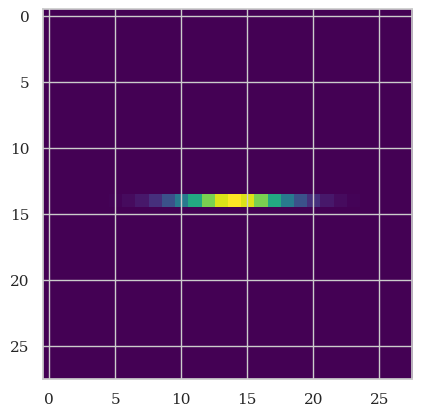

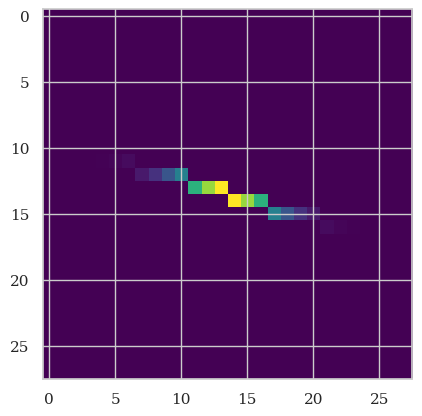

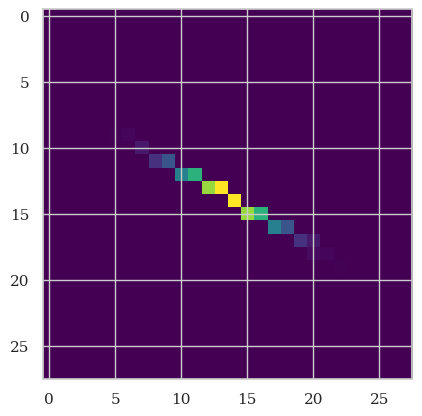

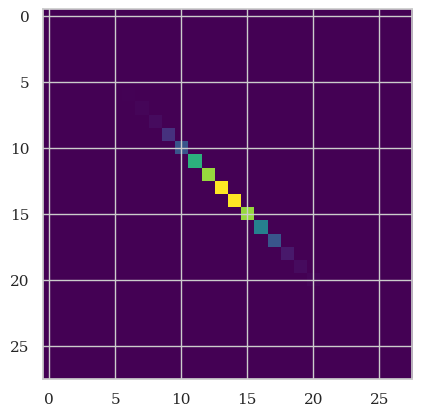

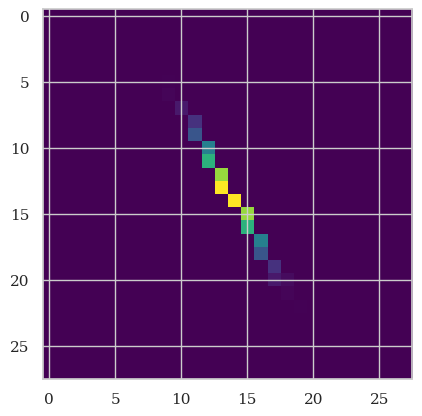

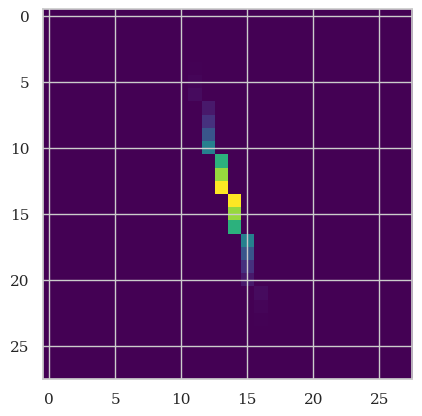

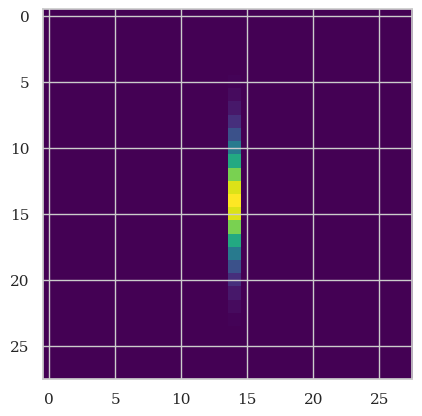

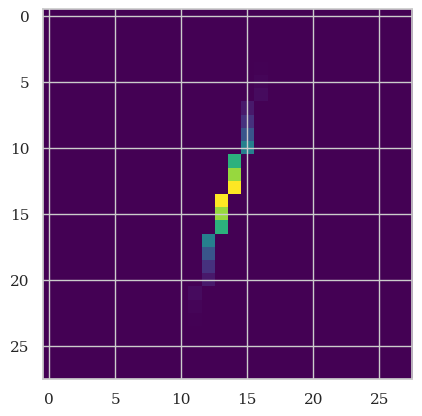

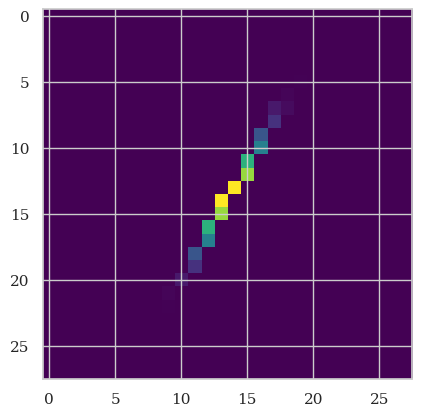

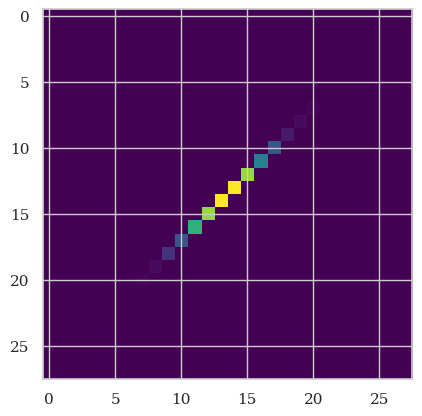

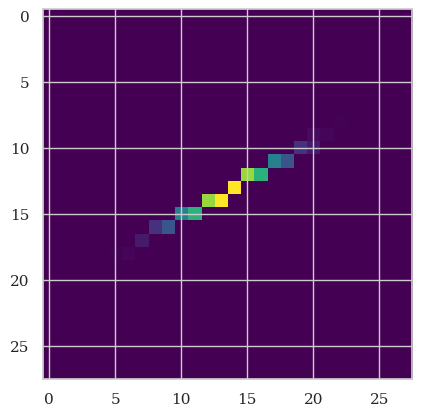

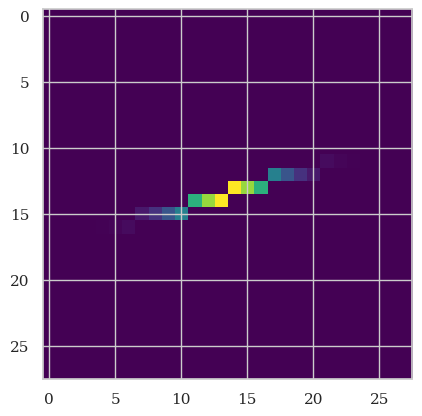

In [46]:

for i in range(len(filters)):
    plt.figure()
    plt.imshow(filters[i], cmap="viridis")


In [47]:
X = []
dirs = np.linspace(0, 180, 12, endpoint=False)
for dir in dirs:
    gaussian_filter_image = create_2d_gaussian_filter(height, width, dir, sigma)
    blurred_images = Parallel(n_jobs=30)(
        delayed(apply_convolution)(image, gaussian_filter_image)
        for image in train_data_numpy
    )
    X.append(blurred_images)

Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not install, you could not use those pipelines
Tensorflow not

In [48]:
domain_train = [0, 1, 2, 3]


In [49]:
psd_domain_welch = []
psd_domain = []

for domain in X:
    psd_welch = []
    psd = []
    for image in domain:
        estimated_psd = compute_psd(image)
        psd.append(estimated_psd)
    psd_domain.append(np.mean(psd, axis=0))

In [50]:
psd_train = [psd_domain[i] for i in domain_train]

In [51]:
psd_bary = np.mean(np.sqrt(psd_train), axis=0) ** 2


In [52]:
from scipy.signal import convolve2d
def apply_convolution2(image, gaussian_filter_image):
    blurred_image = convolve2d(
        image, gaussian_filter_image, mode="same", boundary="wrap"
    )
    return blurred_image

In [53]:
X_align = []
for j in range(len(X)):

    D = np.sqrt(psd_bary) / np.sqrt(psd_domain[j])
    H = scipy.fft.ifft2(D)
    H = np.real(H).reshape(28, 28)
    H = np.fft.fftshift(H, axes=(0, 1))

    aligned_images = Parallel(n_jobs=30)(
        delayed(apply_convolution2)(image, H)
        for image in X[j]
    )

    X_align.append(aligned_images)

X_train_align = np.concatenate([X_align[i] for i in domain_train], axis=0)
X_train_align = X_train_align.reshape(-1, 1, 28, 28).astype(np.float32)


In [54]:
corr_bary = np.fft.fftshift(np.abs(np.fft.ifft2(psd_bary)), axes=(0, 1))

In [55]:
corr_domain = []
for psd in psd_domain:
    corr_domain.append(np.fft.fftshift(np.abs(np.fft.ifft2(psd)), axes=(0, 1)))

In [56]:
psd_original = []
for image in train_data_numpy:
    estimated_psd = compute_psd(image[0])
    psd_original.append(estimated_psd)
psd_original = np.mean(psd_original, axis=0)
corr_original = np.fft.fftshift(np.abs(np.fft.ifft2(psd_original)), axes=(0, 1))

In [65]:
psd_domain_align = []

for domain in X_align:
    psd = []
    for image in domain:
        estimated_psd = compute_psd(image)
        psd.append(estimated_psd)
    psd_domain_align.append(np.mean(psd, axis=0))

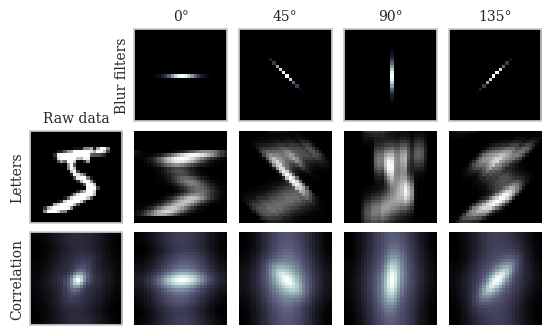

In [90]:
n_rows = 3
n_cols = 5
domain_to_plot = [0, 3, 6, 9]
angle = ["0°", "45°", "90°", "135°"]
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.7, 3.5))

cmap = "bone"
cmap_letters = "gray"
for i in range(n_rows):
    for j in range(n_cols):
        if i == 0:
            if j == 0:
                ax = axes[i, j]
                ax.axis("off")
            else:
                ax = axes[i, j]
                ax.imshow(filters[domain_to_plot[j-1]], cmap=cmap)
                # ax.axis("off")
                if j == 1:
                    ax.set_ylabel("Blur filters", fontsize=10)
                ax.set_title(angle[j-1], fontsize=10)
                ax.set_xticks([])
                ax.set_yticks([])
        elif i == 1:
            if j == 0:
                ax = axes[i, j]
                if i == 1:
                    ax.set_title("Raw data", fontsize=10)
                ax.imshow(train_data_numpy[0][0], cmap=cmap_letters)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylabel(f"Letters", fontsize=10) 
            else:
                ax = axes[i, j]
                ax.imshow(X[domain_to_plot[j-1]][0], cmap=cmap_letters)
                ax.axis("off")
        elif i == 2:
            if j == 0:
                ax = axes[i, j]
                ax.imshow(corr_original, cmap=cmap)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylabel("Correlation", fontsize=10)
            else:
                ax = axes[i, j]
                ax.imshow(corr_domain[domain_to_plot[j-1]], cmap=cmap)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.axis("off")

plt.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig("plots/blur_mnist.pdf", bbox_inches="tight")

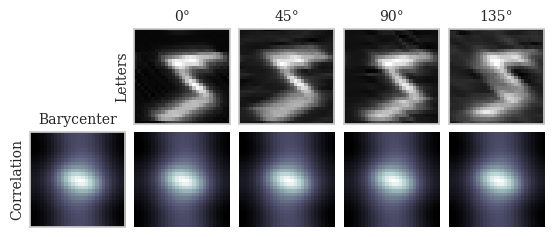

In [94]:
n_rows = 2
n_cols = 5
domain_to_plot = [0, 3, 6, 9]
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.7, 2.5))

for i in range(n_rows):
    for j in range(n_cols):
        if i == 0:
            if j == 0:
                ax = axes[i, j]
                ax.axis("off")
            else:
                ax = axes[i, j]
                ax.imshow(X_align[domain_to_plot[j-1]][0], cmap=cmap_letters)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(angle[j-1], fontsize=10)
                if j == 1:
                    ax.set_ylabel("Letters", fontsize=10)
        elif i == 1:
            if j == 0:
                ax = axes[i, j]
                ax.imshow(corr_bary, cmap=cmap)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_ylabel("Correlation", fontsize=10)
                ax.set_title("Barycenter", fontsize=10)
            else:
                ax = axes[i, j]
                ax.imshow(corr_domain_align[domain_to_plot[j-1]], cmap=cmap)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.axis("off")

plt.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.05)
fig.savefig("plots/align_mnist.pdf", bbox_inches="tight")

In [62]:
len(X_align)

12

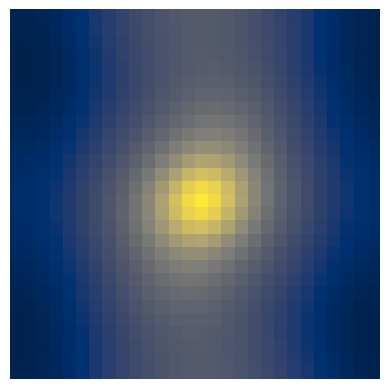

In [ ]:
fig = plt.figure()
plt.imshow(corr_bary, cmap=cmap)
plt.axis("off")
fig.savefig("plots/corr_bary_mnist.pdf")

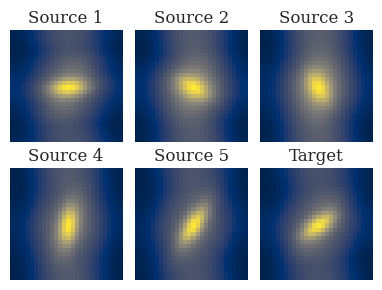

In [ ]:
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4, 3))

cmap = "cividis"
for i, ax in enumerate(axes.flat):
    if i == 5:
        ax.set_title(f"Target")
    else:
        ax.set_title(f"Source {i+1}")
    ax.imshow(corr_domain[i], cmap=cmap)
    ax.axis("off")

plt.tight_layout()
fig.subplots_adjust(wspace=0.1,)
fig.savefig("plots/corr_mnist.pdf")

In [ ]:
psd_domain_align = []
for domain in X_align:
    psd = []
    for image in domain:
        estimated_psd = compute_psd(image)
        psd.append(estimated_psd)
    psd_domain_align.append(np.mean(psd, axis=0))

In [ ]:
corr_domain_align = []
for psd in psd_domain_align:
    corr_domain_align.append(np.fft.fftshift(np.abs(np.fft.ifft2(psd)), axes=(0, 1)))

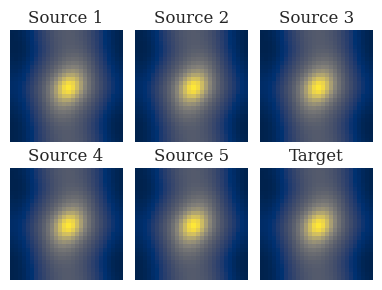

In [ ]:
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4, 3))

cmap = "cividis"
for i, ax in enumerate(axes.flat):
    if i == 5:
        ax.set_title(f"Target")
    else:
        ax.set_title(f"Source {i+1}")
    ax.imshow(corr_domain_align[i], cmap=cmap)
    ax.axis("off")

plt.tight_layout()
fig.subplots_adjust(wspace=0.1,)
fig.savefig("plots/corr_align_mnist.pdf")

In [7]:
def welch_method(image, window_size, overlap_ratio):
    """
    Estimate the power spectral density of an image using the Welch method.

    Parameters:
        image (numpy.ndarray): Input image.
        window_size (int): Size of the window for each segment.
        overlap_ratio (float): Overlap ratio between consecutive segments.

    Returns:
        numpy.ndarray: Estimated power spectral density.
    """
    # Calculate overlap size
    overlap_size = int(window_size * overlap_ratio)

    # Initialize list to store PSDs of each patch
    psd_patches = []

    # Loop over the image, extract patches, and compute PSDs
    for i in range(0, image.shape[0] - window_size + 1, overlap_size):
        for j in range(0, image.shape[1] - window_size + 1, overlap_size):
            patch = image[i:i + window_size, j:j + window_size]

            # Compute FFT of the segment and its squared magnitude
            psd = compute_psd(patch)

            # Store the periodogram of the segment
            psd_patches.append(psd)

    # Average the periodograms of all segments
    # Average the PSDs of all patches
    average_psd = np.mean(psd_patches, axis=0)

    return average_psd


In [15]:
psd_domain_welch = []

for domain in X:
    psd_welch = []
    for image in domain:
        estimated_psd = welch_method(image, window_size=12, overlap_ratio=0.3)
        psd_welch.append(estimated_psd)
    psd_domain_welch.append(np.mean(psd_welch, axis=0))


In [ ]:
test_psd = psd_domain_welch[0]

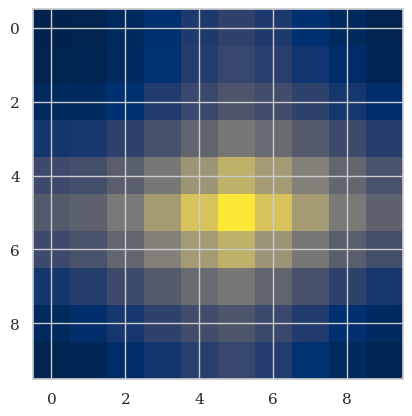

In [14]:
plt.imshow(np.fft.fftshift(np.abs(np.fft.ifft2(test_psd))), cmap="cividis")
